# Cuaderno de Entrenamiento del Modelo de Machine Learning

# Fase 1: Carga y Preparación de Datos

El primer paso es cargar los datos limpios y validados desde nuestra base de datos. Se seleccionan solo las columnas relevantes para la predicción de precios.

In [2]:
import pandas as pd
from sqlalchemy import create_engine
import os
from dotenv import load_dotenv
import warnings

# Ignorar advertencias futuras de pandas para una salida más limpia
warnings.simplefilter(action='ignore', category=FutureWarning)

# Cargar las variables de entorno desde el archivo .env en la raíz
load_dotenv(dotenv_path='../.env')

def get_data_from_db():
    """
    Se conecta a la base de datos usando SQLAlchemy y carga las columnas 
    relevantes para el modelo en un DataFrame.
    """
    try:
        # Construimos la URI de conexión para SQLAlchemy
        db_user = os.getenv("DB_USER")
        db_password = os.getenv("DB_PASSWORD")
        db_host = os.getenv("DB_HOST")
        db_name = os.getenv("DB_NAME")
        
        db_uri = f"mysql+mysqlconnector://{db_user}:{db_password}@{db_host}/{db_name}"
        
        # Creamos el motor de conexión
        engine = create_engine(db_uri)
        
        print("✅ Conectado a la base de datos vía SQLAlchemy. Cargando datos...")
        # Seleccionamos las columnas que servirán como características (features) y objetivo (target)
        query = """
            SELECT 
                price_usd, barrio, ambientes, dormitorios, banos, 
                superficie_total_m2, cocheras 
            FROM propiedades
            WHERE price_usd IS NOT NULL AND superficie_total_m2 IS NOT NULL;
        """
        df = pd.read_sql(query, engine)
        print(f"✅ Se cargaron {len(df)} registros para el modelo.")
        return df
    except Exception as e:
        print(f"❌ Error al conectar o cargar datos desde MySQL: {e}")
        return None

# Cargar los datos para el modelo
df_modelo = get_data_from_db()

if df_modelo is not None:
    print("\nPrimeras 5 filas del DataFrame para el modelo:")
    display(df_modelo.head())
    print("\nInformación general y tipos de datos:")
    df_modelo.info()



✅ Conectado a la base de datos vía SQLAlchemy. Cargando datos...
✅ Se cargaron 50248 registros para el modelo.

Primeras 5 filas del DataFrame para el modelo:


,price_usd,barrio,ambientes,dormitorios,banos,superficie_total_m2,cocheras
0,94500.0,Palermo,3,2,1,50,0
1,190000.0,Recoleta,4,3,1,93,1
2,44500.0,Monserrat,2,1,1,29,0
3,327420.0,Retiro,1,0,0,78,0
4,345000.0,Belgrano,4,4,2,159,1



Información general y tipos de datos:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50248 entries, 0 to 50247
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   price_usd            50248 non-null  float64
 1   barrio               50248 non-null  object 
 2   ambientes            50248 non-null  int64  
 3   dormitorios          50248 non-null  int64  
 4   banos                50248 non-null  int64  
 5   superficie_total_m2  50248 non-null  int64  
 6   cocheras             50248 non-null  int64  
dtypes: float64(1), int64(5), object(1)
memory usage: 2.7+ MB


# Fase 2: Pre-procesamiento de Datos para el Modelo Base

Antes de poder entrenar un modelo, necesitamos preparar los datos:
* 1.  Separar nuestras **características (features)** de nuestra **variable objetivo (target)**.
* 2.  Convertir las variables categóricas (como `barrio`) en un formato numérico que el modelo pueda entender. Para esto se usa la tecnica **One-Hot Encoding**.

In [3]:
if df_modelo is not None:
    # 1. Separar características (X) y objetivo (y)
    X = df_modelo.drop('price_usd', axis=1)
    y = df_modelo['price_usd']
    
    print("Características (X) iniciales:")
    display(X.head())
    print("\nVariable Objetivo (y) inicial:")
    display(y.head())

Características (X) iniciales:


,barrio,ambientes,dormitorios,banos,superficie_total_m2,cocheras
0,Palermo,3,2,1,50,0
1,Recoleta,4,3,1,93,1
2,Monserrat,2,1,1,29,0
3,Retiro,1,0,0,78,0
4,Belgrano,4,4,2,159,1



Variable Objetivo (y) inicial:


0     94500.0
1    190000.0
2     44500.0
3    327420.0
4    345000.0
Name: price_usd, dtype: float64

In [4]:
# 2. Convertir la variable categórica 'barrio' usando One-Hot Encoding
if 'barrio' in X.columns:
    X_codificado = pd.get_dummies(X, columns=['barrio'], drop_first=True, dtype=int)
    
    print("\nCaracterísticas (X) después del One-Hot Encoding:")
    display(X_codificado.head())
    
    print(f"\nEl número de columnas aumentó de {X.shape[1]} a {X_codificado.shape[1]}.")


Características (X) después del One-Hot Encoding:


,ambientes,dormitorios,banos,superficie_total_m2,cocheras,barrio_Almagro,barrio_Balvanera,barrio_Barracas,barrio_Belgrano,barrio_Boedo,...,barrio_Villa Lugano,barrio_Villa Luro,barrio_Villa Ortuzar,barrio_Villa Pueyrredon,barrio_Villa Real,barrio_Villa Riachuelo,barrio_Villa Santa Rita,barrio_Villa Soldati,barrio_Villa Urquiza,barrio_Villa del Parque
0,3,2,1,50,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,4,3,1,93,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,1,1,29,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,78,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,4,2,159,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0



El número de columnas aumentó de 6 a 52.


# Fase 3: División de Datos en Conjuntos de Entrenamiento y Prueba
 
Para evaluar el rendimiento de nuestro modelo de manera objetiva, debemos dividir nuestros datos en dos conjuntos:
   
    - 1.  **Conjunto de Entrenamiento (Training Set)**: La mayor parte de los datos, que usaremos para que el modelo aprenda.
    - 2.  **Conjunto de Prueba (Testing Set):** Una pequeña porción que mantendremos "oculta" para el modelo. La usaremos al final para ver qué tan bien generaliza a datos que nunca ha visto.


In [7]:
from sklearn.model_selection import train_test_split

if 'X_codificado' in locals():
    # Dividimos los datos: 80% para entrenamiento, 20% para prueba
    X_train, X_test, y_train, y_test = train_test_split(
        X_codificado, 
        y, 
        test_size=0.2, 
        random_state=42  # random_state asegura que la división sea siempre la misma
    )
    
    print("División de datos completada.")
    print(f"Tamaño del conjunto de entrenamiento (X_train): {X_train.shape}")
    print(f"Tamaño del conjunto de prueba (X_test): {X_test.shape}")
    print(f"Tamaño del objetivo de entrenamiento (y_train): {y_train.shape}")
    print(f"Tamaño del objetivo de prueba (y_test): {y_test.shape}")



División de datos completada.
Tamaño del conjunto de entrenamiento (X_train): (40198, 52)
Tamaño del conjunto de prueba (X_test): (10050, 52)
Tamaño del objetivo de entrenamiento (y_train): (40198,)
Tamaño del objetivo de prueba (y_test): (10050,)


## Fase 4: Entrenamiento y Evaluación del Modelo Base

# Con los datos listos, entrenaremos nuestro primer modelo, un `RandomForestRegressor`. Luego, se va a medir su rendimiento en el conjunto de prueba utilizando dos métricas clave:
 
* **RMSE (Root Mean Squared Error):** Nos dice, en promedio, qué tan lejos están nuestras predicciones del valor real, en la misma unidad que el precio (USD). Un valor más bajo es mejor.
* **R² (Coeficiente de Determinación):** Mide qué proporción de la varianza en el precio es explicada por nuestro modelo. Va de 0 a 1 (o incluso negativo). Un valor más cercano a 1 es mejor.

In [8]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

if 'X_train' in locals():
    # 1. Inicializar y entrenar el modelo
    print("Entrenando el modelo RandomForestRegressor...")
    # n_jobs=-1 utiliza todos los procesadores disponibles para acelerar el entrenamiento
    modelo_base = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
    modelo_base.fit(X_train, y_train)
    print("✅ Modelo entrenado con éxito.")
    
    # 2. Realizar predicciones en el conjunto de prueba
    print("\nRealizando predicciones en el conjunto de prueba...")
    y_pred = modelo_base.predict(X_test)
    
    # 3. Evaluar el rendimiento del modelo
    print("Evaluando el rendimiento del modelo...")
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    print(f"\n--- Resultados de Evaluación del Modelo Base ---")
    print(f"RMSE (Error Cuadrático Medio Raíz): ${rmse:,.2f} USD")
    print(f"R² (Coeficiente de Determinación): {r2:.4f}")



Entrenando el modelo RandomForestRegressor...
✅ Modelo entrenado con éxito.

Realizando predicciones en el conjunto de prueba...
Evaluando el rendimiento del modelo...

--- Resultados de Evaluación del Modelo Base ---
RMSE (Error Cuadrático Medio Raíz): $155,871.00 USD
R² (Coeficiente de Determinación): 0.8709


# Fase 5: Análisis de Resultados y Persistencia del Modelo

## 5.1 Visualización de Predicciones vs. Valores Reales

Un gráfico de dispersión es una excelente manera de ver el rendimiento del modelo. Si las predicciones fueran perfectas, todos los puntos se alinearían en una línea diagonal perfecta.

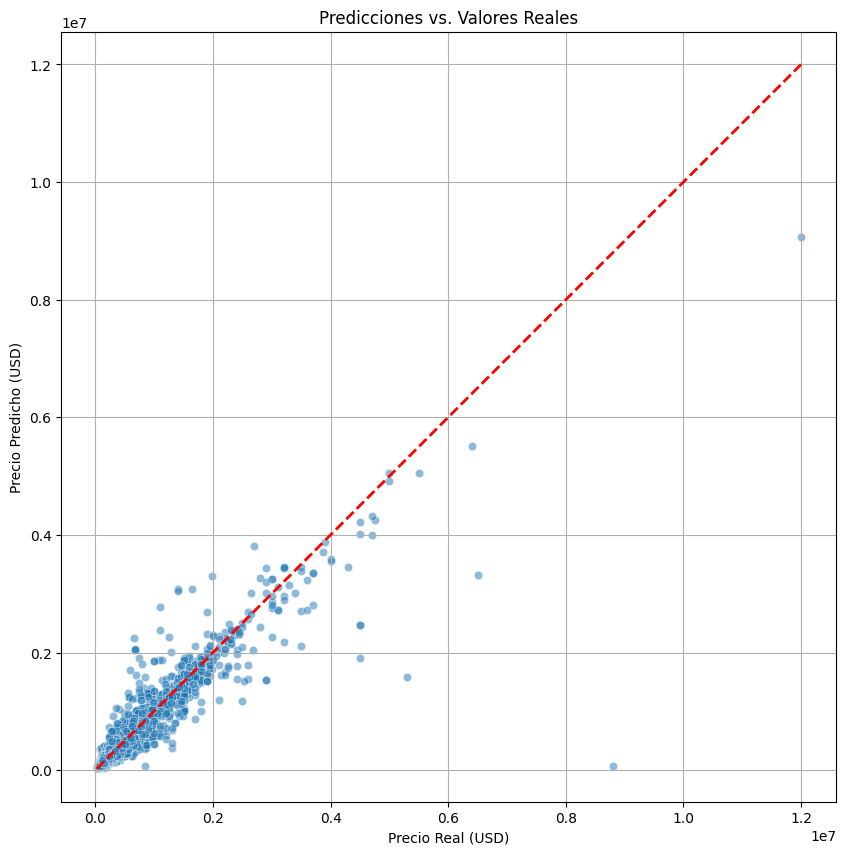

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

if 'y_test' in locals() and 'y_pred' in locals():
    plt.figure(figsize=(10, 10))
    sns.scatterplot(x=y_test, y=y_pred, alpha=0.5)
    
    # Línea de referencia para una prediccionn perfecta (y=x)
    max_val = max(y_test.max(), y_pred.max())
    min_val = min(y_test.min(), y_pred.min())
    plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', lw=2)
    
    plt.title('Predicciones vs. Valores Reales')
    plt.xlabel('Precio Real (USD)')
    plt.ylabel('Precio Predicho (USD)')
    plt.axis('equal') # Asegura que la escala de los ejes sea la misma
    plt.grid(True)
    plt.show()


## 5.2 Guardado del Modelo

Guardamos el modelo entrenado y las columnas que necesita para poder usarlo más tarde en la API.

In [13]:
import pickle

if 'modelo_base' in locals() and 'X_codificado' in locals():
    # Creamos el directorio si no existe (robusto)
    model_dir = '../src/ml/'
    os.makedirs(model_dir, exist_ok=True)
    
    # Guardamos el modelo con el nombre estandarizado del proyecto
    model_path = os.path.join(model_dir, 'model.pkl')
    with open(model_path, 'wb') as f:
        pickle.dump(modelo_base, f)
    
    # Guardamos las columnas del DataFrame con el que se entrenó
    columns_path = os.path.join(model_dir, 'model_columns.pkl')
    model_columns = list(X_codificado.columns)
    with open(columns_path, 'wb') as f:
        pickle.dump(model_columns, f)
        
    print(f"✅ Modelo guardado en: {model_path}")
    print(f"✅ Columnas del modelo guardadas en: {columns_path}")

✅ Modelo guardado en: ../src/ml/model.pkl
✅ Columnas del modelo guardadas en: ../src/ml/model_columns.pkl
